# Bài 5 Xây đựng mô hình phân đoạn tế bào máu

## a) Cài đặt và huấn luyện mô hình Unet

### 1. Chuẩn bị dữ liệu

Ảnh mẫu: ['/kaggle/input/bccd-dataset-with-mask/BCCD Dataset with mask/train/original/1c87b997-a8e6-48ca-bf40-19b9a7fd6a96.png', '/kaggle/input/bccd-dataset-with-mask/BCCD Dataset with mask/train/original/b426ef1d-4a59-4f90-b593-50226af60a60.png', '/kaggle/input/bccd-dataset-with-mask/BCCD Dataset with mask/train/original/4c13e22e-dfd1-4fa1-b373-be9d0c272c0f.png']


Mask mẫu: ['/kaggle/input/bccd-dataset-with-mask/BCCD Dataset with mask/train/mask/1c87b997-a8e6-48ca-bf40-19b9a7fd6a96.png', '/kaggle/input/bccd-dataset-with-mask/BCCD Dataset with mask/train/mask/b426ef1d-4a59-4f90-b593-50226af60a60.png', '/kaggle/input/bccd-dataset-with-mask/BCCD Dataset with mask/train/mask/4c13e22e-dfd1-4fa1-b373-be9d0c272c0f.png']


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


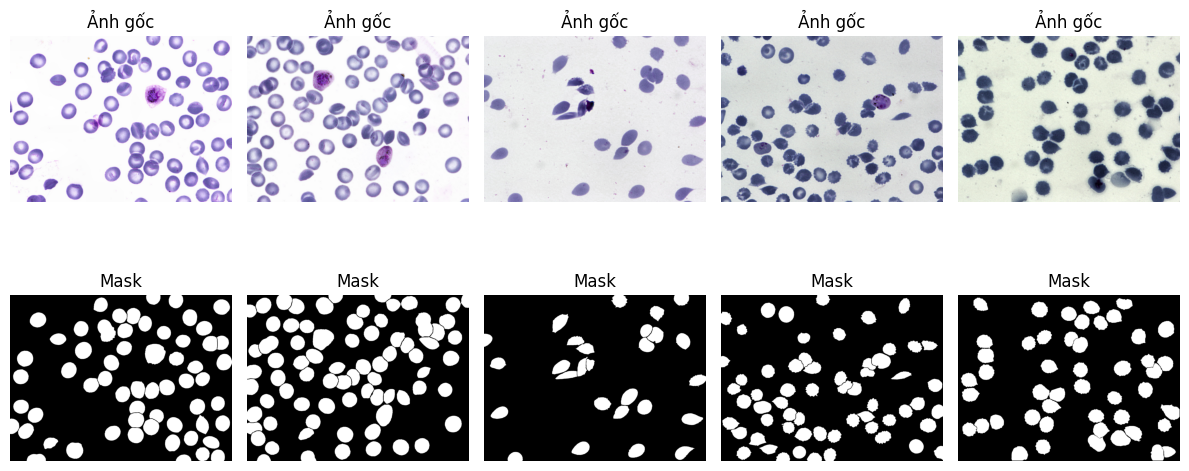

In [1]:
import matplotlib.pyplot as plt
import cv2, os, glob

# Thư mục chứa ảnh và mask (bạn đổi path theo dataset của bạn)
IMG_DIR = "/kaggle/input/bccd-dataset-with-mask/BCCD Dataset with mask/train/original"
MASK_DIR = "/kaggle/input/bccd-dataset-with-mask/BCCD Dataset with mask/train/mask"

print("Ảnh mẫu:", glob.glob(os.path.join(IMG_DIR, "*"))[:3])
print("Mask mẫu:", glob.glob(os.path.join(MASK_DIR, "*"))[:3])

# Lấy danh sách ảnh
img_paths = sorted(glob.glob(os.path.join(IMG_DIR, "*.png")))

# Hàm visualize
def visualize_samples(n=5, size=(12, 6)):
    plt.figure(figsize=size)
    for i in range(n):
        img_path = img_paths[i]
        name = os.path.basename(img_path)
        mask_path = os.path.join(MASK_DIR, name)

        # Đọc ảnh và mask
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Vẽ
        plt.subplot(2, n, i+1)
        plt.imshow(img)
        plt.title("Ảnh gốc")
        plt.axis("off")

        plt.subplot(2, n, n+i+1)
        plt.imshow(mask, cmap="gray")
        plt.title("Mask")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Gọi hàm để xem thử 5 cặp ảnh-mask
visualize_samples(n=5)


Tổng số ảnh: 1063
Tổng số mask: 1169


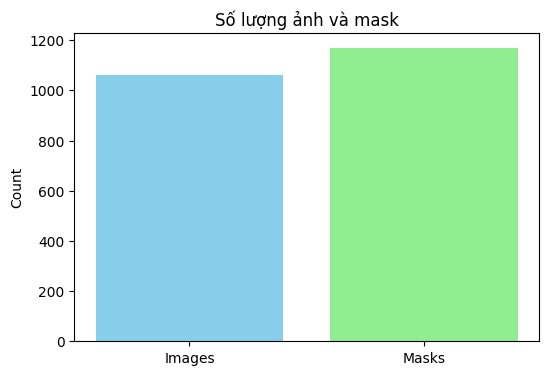

In [2]:
import matplotlib.pyplot as plt
import cv2, os, glob
import numpy as np


# Lấy danh sách ảnh và mask
img_paths = sorted(glob.glob(os.path.join(IMG_DIR, "*.png")))
mask_paths = sorted(glob.glob(os.path.join(MASK_DIR, "*.png")))

print(f"Tổng số ảnh: {len(img_paths)}")
print(f"Tổng số mask: {len(mask_paths)}")

# --- 1. Bar chart số lượng ---
plt.figure(figsize=(6,4))
plt.bar(["Images", "Masks"], [len(img_paths), len(mask_paths)], color=["skyblue", "lightgreen"])
plt.title("Số lượng ảnh và mask")
plt.ylabel("Count")
plt.show()

# --- 2. Histogram phân bố pixel foreground trong mask ---
# foreground_pixels = []
# for mask_path in mask_paths:
#     mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
#     # Đếm số pixel > 0 (tế bào)
#     foreground_pixels.append(np.sum(mask > 127))

# plt.figure(figsize=(6,4))
# plt.hist(foreground_pixels, bins=20, color="orange", edgecolor="black")
# plt.title("Phân bố số pixel foreground trong mask")
# plt.xlabel("Số pixel foreground (trắng)")
# plt.ylabel("Số lượng ảnh")
# plt.show()


### 2. Dataset & DataLoader

In [3]:
import os, cv2, torch, glob
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CellDataset(Dataset):
    def __init__(self, img_dir, mask_dir, size=256, train=True):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.size = size

        # Lấy danh sách file hợp lệ
        img_names = {os.path.splitext(os.path.basename(f))[0] 
                     for f in glob.glob(os.path.join(img_dir, "*"))}
        mask_names = {os.path.splitext(os.path.basename(f))[0] 
                      for f in glob.glob(os.path.join(mask_dir, "*"))}
        common = sorted(list(img_names & mask_names))
        self.file_names = common
        print(f"Tìm thấy {len(self.file_names)} cặp ảnh-mask hợp lệ.")

        # Augmentation
        if train:
            self.tf = A.Compose([
                A.Resize(size, size),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.RandomRotate90(p=0.5),
                A.ShiftScaleRotate(
                    shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5
                ),
                A.RandomBrightnessContrast(p=0.5),
                A.HueSaturationValue(p=0.3),
                A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.2),
                A.Normalize(),
                ToTensorV2()
            ])
        else:
            self.tf = A.Compose([
                A.Resize(size, size),
                A.Normalize(),
                ToTensorV2()
            ])

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        name = self.file_names[idx]

        # tìm file ảnh
        img_path = None
        for ext in [".png", ".jpg", ".jpeg"]:
            path = os.path.join(self.img_dir, name + ext)
            if os.path.exists(path):
                img_path = path
                break
        if img_path is None:
            raise FileNotFoundError(f"Không tìm thấy ảnh cho {name}")

        # tìm file mask
        mask_path = None
        for ext in [".png", ".jpg", ".jpeg"]:
            path = os.path.join(self.mask_dir, name + ext)
            if os.path.exists(path):
                mask_path = path
                break
        if mask_path is None:
            raise FileNotFoundError(f"Không tìm thấy mask cho {name}")

        # đọc ảnh RGB
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # đọc mask (ảnh xám → nhị phân)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 127).astype("float32")

        # augment
        aug = self.tf(image=img, mask=mask)
        img = aug["image"]                       # (3,H,W)
        mask = aug["mask"].unsqueeze(0).float()  # (1,H,W)

        return img, mask


/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
dataset = CellDataset(IMG_DIR, MASK_DIR, size=256, train=True)

img, mask = dataset[0]
print("Ảnh:", img.shape, img.dtype)
print("Mask:", mask.shape, mask.dtype, mask.min().item(), mask.max().item())


Tìm thấy 1169 cặp ảnh-mask hợp lệ.


/usr/local/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


/tmp/ipykernel_74/2450750632.py:33: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.2),


libpng warning: iCCP: known incorrect sRGB profile


Ảnh: torch.Size([3, 256, 256]) torch.float32


Mask: torch.Size([1, 256, 256]) torch.float32 0.0 1.0


In [5]:
from torch.utils.data import DataLoader, random_split

# Tạo dataset
full_dataset = CellDataset(IMG_DIR, MASK_DIR, size=256, train=True)

# Chia train/val (80/20)
val_ratio = 0.2
val_size = int(len(full_dataset) * val_ratio)
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Dataloader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)

Tìm thấy 1169 cặp ảnh-mask hợp lệ.


/tmp/ipykernel_74/2450750632.py:33: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.2),


In [6]:
train_loader

### 3. Mô hình U-Net

In [7]:
!pip install segmentation-models-pytorch --quiet
!pip install timm --quiet  # cần cho các encoder


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [8]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet34",     # backbone
    encoder_weights="imagenet",  # pretrained
    in_channels=3,               
    classes=1,                   
)
# print(model)

### 4. Loss function & Optimizer

In [9]:
import torch
import torch.nn as nn

def dice_loss(pred, target, smooth=1.0):
    pred = torch.sigmoid(pred)
    pred = pred.view(-1)
    target = target.view(-1)

    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return 1 - dice

class BCEDiceLoss(nn.Module):
    def __init__(self, bce_weight=0.5):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.bce_weight = bce_weight

    def forward(self, pred, target):
        bce = self.bce(pred, target)
        d_loss = dice_loss(pred, target)
        return self.bce_weight * bce + (1 - self.bce_weight) * d_loss


### 5. Huấn luyện & Theo dõi

In [10]:
pip install torchmetrics==1.4.2 --quiet


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


### 6. Train

In [11]:
from torchmetrics.classification import BinaryJaccardIndex, BinaryF1Score
from tqdm.auto import tqdm


def train(model, train_loader, val_loader, epochs=20):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    train_losses, val_losses, ious, dices = [], [], [], []

    for epoch in range(epochs):
        # metrics mới cho mỗi epoch
        iou = BinaryJaccardIndex(threshold=0.5).to(device)
        dice = BinaryF1Score(threshold=0.5).to(device)

        # ---- Training ----
        model.train()
        train_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)
        for imgs, masks in loop:
            imgs, masks = imgs.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = loss_fn(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            loop.set_postfix(loss=loss.item())
        train_loss /= len(train_loader)

        # ---- Validation ----
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for imgs, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=False):
                imgs, masks = imgs.to(device), masks.to(device)
                outputs = model(imgs)
                val_loss += loss_fn(outputs, masks).item()
                probs = torch.sigmoid(outputs)
                iou.update(probs, masks.int())
                dice.update(probs, masks.int())
        val_loss /= len(val_loader)
        val_iou = iou.compute()
        val_dice = dice.compute()

        # lưu lịch sử
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        ious.append(val_iou.item())
        dices.append(val_dice.item())

        print(f"Epoch {epoch+1}/{epochs} "
              f"Train Loss: {train_loss:.4f} "
              f"Val Loss: {val_loss:.4f} "
              f"IoU: {val_iou:.4f} "
              f"Dice: {val_dice:.4f}")

    return train_losses, val_losses, ious, dices


/usr/local/lib/python3.10/site-packages/torch_xla/__init__.py:251: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


In [12]:
from torch.utils.data import DataLoader, random_split

IMG_DIR = "/kaggle/input/bccd-dataset-with-mask/BCCD Dataset with mask/train/original"
MASK_DIR = "/kaggle/input/bccd-dataset-with-mask/BCCD Dataset with mask/train/mask"

# Tạo full dataset
full_dataset = CellDataset(IMG_DIR, MASK_DIR, size=256, train=True)

# Chia train/val theo tỉ lệ 80/20
val_ratio = 0.2
val_size = int(len(full_dataset) * val_ratio)
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Dataloader (đặt num_workers=0 để tránh crash trên Kaggle/Colab)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=1)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=1)


Tìm thấy 1169 cặp ảnh-mask hợp lệ.


/usr/local/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


/tmp/ipykernel_74/2450750632.py:33: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.2),


In [13]:
loss_fn = BCEDiceLoss(bce_weight=0.5)
train_losses, val_losses, ious, dices = train(model, train_loader, val_loader, epochs=1)

Epoch 1/1 [Train]:   0%|          | 0/234 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


NameError: name 'optimizer' is not defined

### 7. Vẽ biểu đồ

In [ ]:
import matplotlib.pyplot as plt

# Sau khi train, lưu lịch sử loss, metric vào list và vẽ:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend(); plt.show()


## b) Thử nghiệm trên một số mô hình

In [ ]:
import segmentation_models_pytorch as smp

def build_model(kind: str, in_ch=3, n_classes=1, pretrained=True):
    """
    kind ∈ {'unet','unet++','att-unet','resunet','swin-unet'}
    """
    enc_w = "imagenet" if pretrained else None

    if kind == "unet":
        return smp.Unet(
            encoder_name="resnet34", 
            encoder_weights=enc_w,
            in_channels=in_ch, 
            classes=n_classes
        )

    if kind == "unet++":  # Dense skip connections
        return smp.UnetPlusPlus(
            encoder_name="resnet34", 
            encoder_weights=enc_w,
            in_channels=in_ch, 
            classes=n_classes
        )

    if kind == "att-unet":  # Attention U-Net: dùng scSE attention ở decoder
        return smp.Unet(
            encoder_name="resnet34", 
            encoder_weights=enc_w,
            in_channels=in_ch, 
            classes=n_classes,
            decoder_attention_type="scse"
        )

    if kind == "resunet":
        # Residual U-Net: encoder ResNet50 + decoder U-Net
        return smp.Unet(
            encoder_name="resnet50", 
            encoder_weights=enc_w,
            in_channels=in_ch, 
            classes=n_classes
        )

    if kind == "swin-unet":
        # Thay vì Swin (chưa hỗ trợ), dùng SegFormer encoder (Transformer-based)
        return smp.Unet(
            encoder_name="mit_b0",   # có thể thử mit_b1, mit_b2,... nếu muốn mạnh hơn
            encoder_weights=enc_w,
            in_channels=in_ch, 
            classes=n_classes
        )

    raise ValueError(f"Unknown kind: {kind}")


In [ ]:
import torch
results = []

variants = [
    ("unet", {}),
    # ("unet++", {}),
    ("att-unet", {}),
    ("resunet", {}),
    # ("swin-unet", {}),
]

EPOCHS = 1  # để thử nhanh; khi nộp bài có thể tăng 25–40
LR = 1e-3

for kind, cfg in variants:
    print(f"\n==== Training {kind} ====")
    model = build_model(kind, **cfg)

    # optimizer mới cho từng mô hình
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    # (giữ nguyên loss_fn của bạn: BCEDiceLoss)
    train_losses, val_losses, ious, dices = train(model, train_loader, val_loader, epochs=EPOCHS)

    results.append({
        "model": kind,
        "best_epoch": int(max(range(EPOCHS), key=lambda i: ious[i])) + 1,
        "best_iou": max(ious),
        "best_dice": max(dices),
        "final_iou": ious[-1],
        "final_dice": dices[-1],
        "val_loss_last": val_losses[-1],
    })

# In bảng kết quả
for r in results:
    print(f"{r['model']:10s} | best IoU={r['best_iou']:.4f} (epoch {r['best_epoch']}) | "
          f"best Dice={r['best_dice']:.4f} | final IoU={r['final_iou']:.4f}")


In [ ]:
best = {"iou": -1, "state": None, "kind": None}

for kind, _ in variants:
    model = build_model(kind)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    tl, vl, iou_curve, dice_curve = train(model, train_loader, val_loader, epochs=EPOCHS)
    if max(iou_curve) > best["iou"]:
        best = {"iou": max(iou_curve), "state": model.state_dict(), "kind": kind}

# lưu mô hình tốt nhất
torch.save(best["state"], f"best_{best['kind']}_weights.pth")
print("Best model:", best["kind"], "IoU:", best["iou"])


In [ ]:
# import matplotlib.pyplot as plt
# import torch

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# def run_and_plot(kind, color=None, fast_debug=False):
#     """
#     Huấn luyện 1 model và plot IoU curve.
#     - kind: tên biến thể ('unet','unet++','swin-unet',...)
#     - fast_debug=True: chỉ chạy 1 batch để test nhanh
#     """
#     model = build_model(kind).to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=LR)

#     # train có hỗ trợ chạy nhanh
#     tl, vl, iou_curve, dice_curve = train(
#         model,
#         train_loader,
#         val_loader,
#         epochs=EPOCHS,
#         max_batches=1 if fast_debug else None
#     )

#     plt.plot(iou_curve, label=kind)
#     return tl, vl, iou_curve, dice_curve


# # ==========================
# # Plot so sánh nhiều model
# # ==========================
# plt.figure(figsize=(7, 4))
# for k in ["unet", "unet++", "swin-unet"]:
#     _ = run_and_plot(k, fast_debug=True)   # để nhanh thì bật fast_debug
# plt.title("IoU theo epoch (val)")
# plt.xlabel("Epoch")
# plt.y
